In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, rankdata
import os
import seaborn as sb
import pickle
from pprint import pprint

In [5]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [6]:
folder = "/Users/clemens/Documents/courses/DSLabData"


data = pd.read_csv(os.path.join(folder,"feature_data_7.csv"))
data.head()

data_neg = data[data["label"]==0]
data_gt = data[data["label"]==1]

age_vals_pos = data_gt["question_age"]
age_vals_neg = data_neg["question_age"]
plt.figure(figsize=(10,7))
sb.distplot(age_vals_pos, label='pos', bins=np.arange(0,1, 0.02))
sb.distplot(age_vals_neg, label='neg', bins=np.arange(0,1, 0.02))
plt.xlim(0,1)
plt.ylabel("Number of questions in data")
plt.xlabel("Question age (in days)")
plt.legend()
plt.savefig("../../overleaf images/question_age_at_answering.pdf")
plt.show()

## Analysis of outputs

In [7]:
data = pd.read_csv(os.path.join(folder, "final_baseline_2015_woQA.csv"))
# data.head(30)

plt.hist(data["rank"], bins=np.arange(-2,20,0.5))
plt.show()

### compute rolling average

In [8]:
# general params

win_size = 500

In [9]:
def compute_chance_success(n_candidates_list, n):
    p = n/np.array(n_candidates_list)
    p[p>1] = 1 # if there n_preds smaller then candidate list
    return p

In [10]:
# replace by -1 so it is the same in your data. Note thought that the best rank is 1, is it 0 in your case?
data.loc[data["rank"]>5, "rank"] = -1

In [11]:

data.loc[:, "is_found"] = (data["rank"].values!=-1)*1.0 # modified
data.loc[:, "chance_success"] = compute_chance_success(data.n_candidates, 5)
r_mean_rf = data.is_found.rolling(win_size).mean()
c_mean_rf = data.chance_success.rolling(win_size).mean()

In [12]:
data.loc[:, "event_time"] = pd.to_datetime(data.answer_date)
time_indx_rf = pd.to_timedelta(data.event_time- data.event_time.min()) / pd.Timedelta(365, 'D')

Text(0.5, 1.0, 'RF trained on data<2015, test is 2016, without question age')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


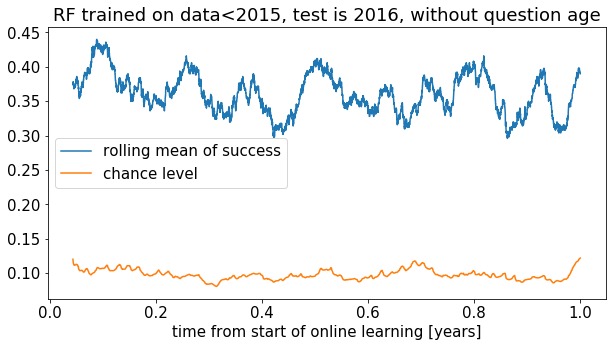

In [13]:
plt.figure(figsize=(10,5))
# sb.regplot(time_indx.values, r_mean)
plt.plot(time_indx_rf.values, r_mean_rf, label='rolling mean of success')
plt.plot(time_indx_rf.values, c_mean_rf, label='chance level')
plt.legend()
plt.xlabel("time from start of online learning [years]")
plt.title("RF trained on data<2015, test is 2016, without question age")
# plt.savefig("../../overleaf images/baseline_RF_woQU.png")

Text(0.5, 1.0, 'Difference between RF test preds and chance level')

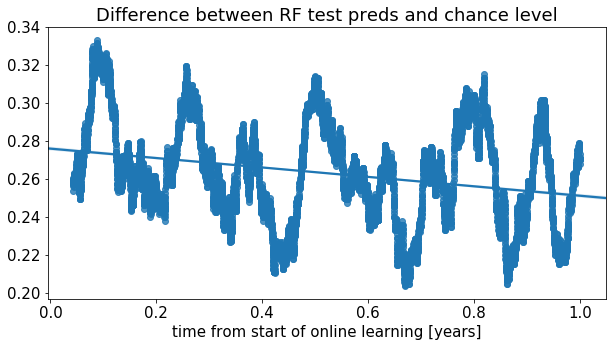

In [14]:
plt.figure(figsize=(10,5))
sb.regplot(time_indx_rf.values, r_mean_rf-c_mean_rf)
plt.xlabel("time from start of online learning [years]")
plt.title("Difference between RF test preds and chance level")
# plt.savefig("../../overleaf images/differenceRF.png")

Text(0.5, 1.0, 'RF trained on data<2015, test is 2016, without question age')

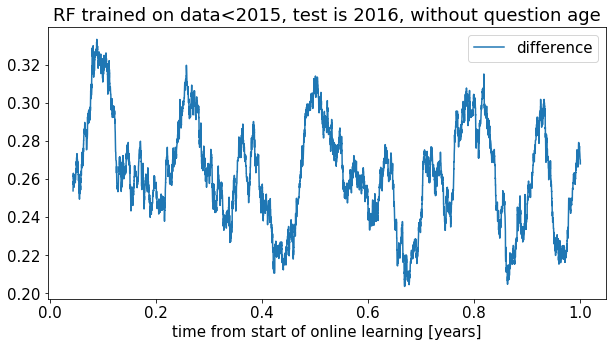

In [15]:
# normal plot instead of seaborn plot
plt.figure(figsize=(10,5))
plt.plot(time_indx_rf.values, r_mean_rf-c_mean_rf, label='difference')
# plt.plot(time_indx.values, c_mean, label='chance level')
plt.legend()
plt.xlabel("time from start of online learning [years]")
plt.title("RF trained on data<2015, test is 2016, without question age")
# plt.savefig("../../overleaf images/baseline_RF_woQU.png")

In [16]:
dec = np.unique(data["decision_time"], return_counts=True)

In [17]:
data_first_half = data[data["decision_time"]<dec[int(len(dec)/2)]]
data_second_half = data[data["decision_time"]>dec[int(len(dec)/2)]]

In [18]:
print(np.mean(data_first_half["n_candidates"]))
print(np.mean(data_second_half["n_candidates"]))


nan
54.02024524730475


# GP stuff

----------------------------------------------------------------------
{'cache_file_path': 'DSLab-StackOverflow/cache/',
 'k_len': 0.8,
 'k_var': 1.0,
 'kernel': 'linear',
 'log_mu_sigma': False,
 'm': 100,
 'model_choice': 'osgpr',
 'only_use_features': 'votes_sd affinity_sum tag_popularity votes_mean '
                      'cumulative_term_entropy',
 'opt_steps': 20,
 'pretrain_steps': 50,
 'redo_pretraining': False,
 'save_every_n': 1000,
 'save_n_neg': 1,
 'sum_file_path': '/cluster/scratch/huttercl/runs/',
 'verbose_opt': 'pretraining'}
total_succes at n 0.2322442597317093


/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


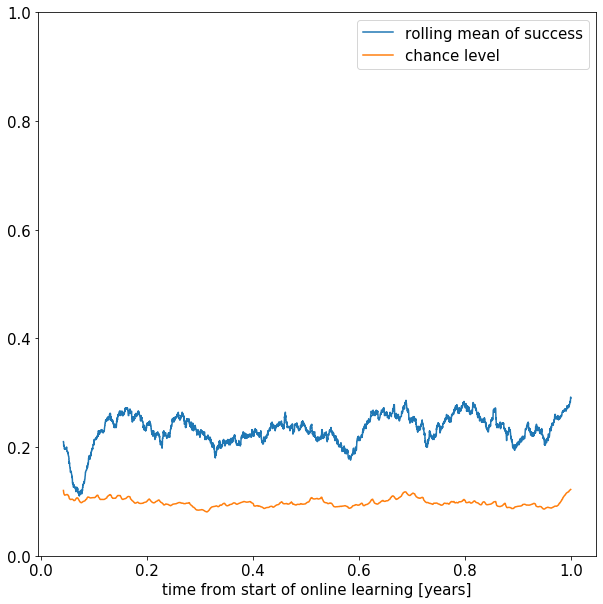

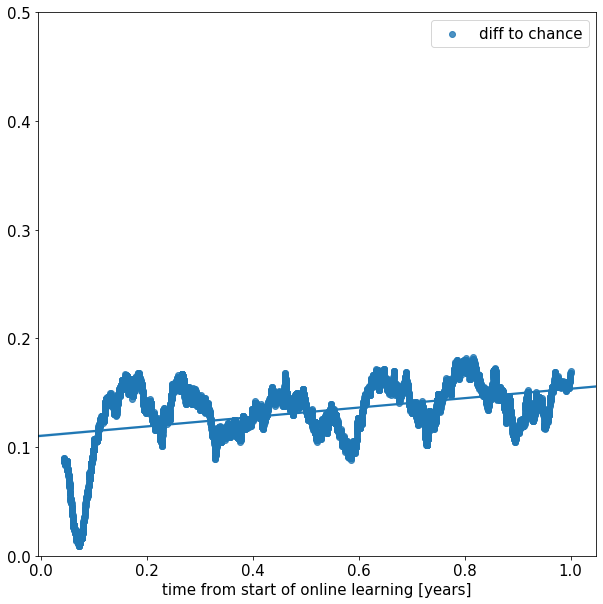

In [22]:
run_path = os.path.join(folder, "runs", "run_summary_12_10__13_48_00.pickle")
with open(run_path, "rb") as f:
    summary = pickle.load(f)

params = summary['params']
info_gp = summary['gp_run_info']
info_gp.loc[:, "event_time"] = pd.to_datetime(info_gp.event_time)
time_indx_gp = pd.to_timedelta(info_gp.event_time-info_gp.event_time.min()) / pd.Timedelta(365, 'D')
info_gp.loc[:, "years_from_start"] = time_indx_gp

info_gp = info_gp[time_indx_gp < 1.0]
print("-"*70)
pprint(params)

start_val = 0
info_gp.loc[:, "is_found"] = (info_gp.predicted_rank != -1)*1.0
info_gp.loc[:, "chance_success"] = compute_chance_success(info_gp.n_candidates, 5)
r_mean_gp = info_gp.is_found.rolling(win_size).mean()
c_mean_gp = info_gp.chance_success.rolling(win_size).mean()

total_succes_at_n = np.mean(info_gp.is_found)
print("total_succes at n {}".format(total_succes_at_n))

plt.figure(figsize=(10,10))
plt.plot(info_gp.years_from_start, r_mean_gp, label='rolling mean of success')
plt.plot(info_gp.years_from_start, c_mean_gp, label='chance level')
plt.legend()
plt.ylim(0, 1)
plt.xlabel("time from start of online learning [years]")


gp_perf = (r_mean_gp - c_mean_gp)[start_val:]
gp_time = info_gp.years_from_start.values[start_val:]
plt.figure(figsize=(10,10))
sb.regplot(gp_time, gp_perf, label='diff to chance')
plt.legend()
plt.xlabel("time from start of online learning [years]")
plt.ylim(0, 0.5)
plt.pause(0.2)



In [20]:
assert(np.all(info_gp.years_from_start == time_indx_rf))
assert(np.all(c_mean_rf[np.isfinite(c_mean_rf)] == c_mean_gp[np.isfinite(c_mean_gp)]))

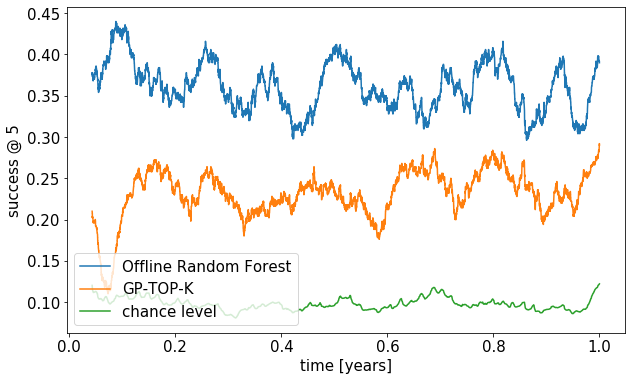

In [21]:
figBoth, axisBoth = plt.subplots(figsize=(10,6))
axisBoth.plot(time_indx_rf, r_mean_rf, label="Offline Random Forest")
axisBoth.plot(time_indx_rf, r_mean_gp, label="GP-TOP-K")
axisBoth.plot(time_indx_rf, c_mean_gp, label="chance level")
axisBoth.legend(loc="lower left")
plt.xlabel("time [years]")
plt.ylabel("success @ 5")
figBoth.savefig("./plots/gp_vs_rf.pdf")


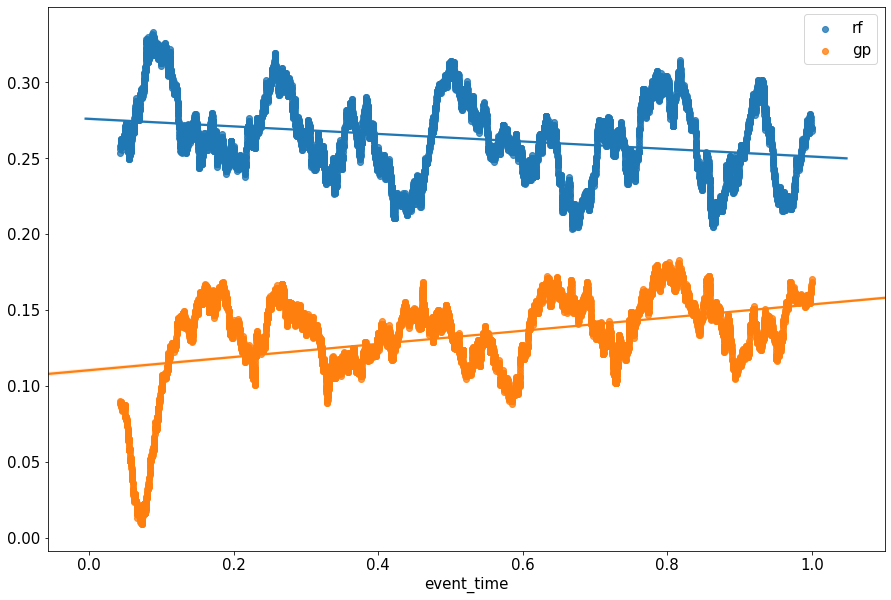

In [47]:
figBoth_diff, axisBoth_diff = plt.subplots(figsize=(15,10))
sb.regplot(time_indx_rf, r_mean_rf-c_mean_rf, label="rf", ax=axisBoth_diff)
sb.regplot(time_indx_rf, r_mean_gp-c_mean_gp, label="gp", ax=axisBoth_diff)
# axisBoth_diff.plot(time_indx_rf, c_mean_gp, label="chance_level")
plt.legend()

# Analyze young versus old users

In [ ]:
data = pd.read_csv("../Baselines/results/ranks_2016_woQA.csv")

In [ ]:
data_gt = data[data["label"]==1]

In [ ]:
x1 = data_gt[data_gt["ans_num_posts"]==0]
x2 = data_gt[data_gt["ans_num_posts"]>0]
plt.figure(figsize=(10,7))
sb.distplot(x1["rank"], label='new users (no posts)', bins=np.arange(0,90, 1))
sb.distplot(x2["rank"], label='users with at least one post', bins=np.arange(0,90, 1))
# sb.distplot(data["rank"], label='all questions (including negatives)', bins=np.arange(0,90, 1))
plt.xlim(0,70)
plt.ylabel("Percentage of data")
plt.xlabel("Rank")
plt.legend(fontsize=15)
plt.title("Performance of Random Forest on old versus young users")
# plt.savefig("../../overleaf images/youngVSold_RF.png")
plt.show()

In [ ]:
from scipy import stats

In [ ]:
print("compare means: Mean young users:", np.mean(x1["rank"]), " Mean old users:", np.mean(data["rank"]))
ks_val = stats.ks_2samp(x1["rank"], x2["rank"])
print("ks test p value (if high, then same distribution)", ks_val[1], "\n")

## Plot The top 10 words

In [3]:
import pickle
with open("/Users/clemens/Documents/courses/DS-Lab/Baselines/top_n.pickle", "rb") as f:
    top10 = pickle.load(f)

In [12]:
"x".join([1,2,3
         ])

TypeError: sequence item 0: expected str instance, int found

In [40]:
def print_topics(tops):

    out = " \\\\ \n".join([" & ".join(kth) for kth in zip(*tops)])
    out2 = out.replace("_", "\_") + " \\\\"
    print(out2)
#     return out2

In [41]:
print_topics(top10)

distribution & data & ne & test & x\_ & time & model & data & lt & nl \\ 
sample & set & model & group & frac & data & regression & question & data & na \\ 
mean & using & data & data & amp & series & variables & like & gt & false \\ 
value & matrix & lt & different & theta & model & variable & number & function & true \\ 
data & use & gt & groups & right & like & linear & statistics & plot & class \\ 
test & training & value & treatment & sigma & day & data & know & code & structure \\ 
standard & class & factor & use & left & year & using & people & nbsp & names \\ 
probability & algorithm & error & analysis & beta & using & models & problem & length & factor \\ 
values & problem & df & effect & hat & use & use & probability & rnorm & n\_ \\ 
normal & features & intercept & significant & y\_ & arima & values & use & matrix & iris \\


In [29]:
print_topics(top10[5:])

time & model & data & lt & nl \\ 
data & regression & question & data & na \\ 
series & variables & like & gt & false \\ 
model & variable & number & function & true \\ 
like & linear & statistics & plot & class \\ 
day & data & know & code & structure \\ 
year & using & people & nbsp & names \\ 
using & models & problem & length & factor \\ 
use & use & probability & rnorm & n_ \\ 
arima & values & use & matrix & iris


In [35]:
'distribution & data & ne & test & x_ & time & model & data & lt & nl \\\\ \nsample & set & model & group & frac & data & regression & question & data & na \\\\ \nmean & using & data & data & amp & series & variables & like & gt & false \\\\ \nvalue & matrix & lt & different & theta & model & variable & number & function & true \\\\ \ndata & use & gt & groups & right & like & linear & statistics & plot & class \\\\ \ntest & training & value & treatment & sigma & day & data & know & code & structure \\\\ \nstandard & class & factor & use & left & year & using & people & nbsp & names \\\\ \nprobability & algorithm & error & analysis & beta & using & models & problem & length & factor \\\\ \nvalues & problem & df & effect & hat & use & use & probability & rnorm & n_ \\\\ \nnormal & features & intercept & significant & y_ & arima & values & use & matrix & iris'.replace("_", "\_")

'distribution & data & ne & test & x\\_ & time & model & data & lt & nl \\\\ \nsample & set & model & group & frac & data & regression & question & data & na \\\\ \nmean & using & data & data & amp & series & variables & like & gt & false \\\\ \nvalue & matrix & lt & different & theta & model & variable & number & function & true \\\\ \ndata & use & gt & groups & right & like & linear & statistics & plot & class \\\\ \ntest & training & value & treatment & sigma & day & data & know & code & structure \\\\ \nstandard & class & factor & use & left & year & using & people & nbsp & names \\\\ \nprobability & algorithm & error & analysis & beta & using & models & problem & length & factor \\\\ \nvalues & problem & df & effect & hat & use & use & probability & rnorm & n\\_ \\\\ \nnormal & features & intercept & significant & y\\_ & arima & values & use & matrix & iris'

# Data used for online training

In [74]:
import sys
import numpy as np

sys.path.append("/Users/clemens/Documents/courses/DS-Lab/Baselines/")

from data import Data
db_access = Data()

In [46]:
import pandas as pd
all_events_file = "/Users/clemens/Documents/courses/DS-Lab/cache/gp/all_events.pickle"
all_events_dataframe = pd.read_pickle(all_events_file)

In [61]:
start_time_online_learning =  data_utils.make_datetime("01.01.2015 00:01")
end_time_online_learning = data_utils.make_datetime("31.12.2015 23:59")
db_access.set_time_range(start = start_time_online_learning, end = end_time_online_learning)

In [57]:
all_events_pretraining_dataframe = all_events_dataframe[all_events_dataframe.answer_date < start_time_online_learning]
all_events_main_timewindow = all_events_dataframe[
    (all_events_dataframe.answer_date >= start_time_online_learning) &
    (all_events_dataframe.answer_date <= end_time_online_learning)
]

In [70]:
print("total usable user answers events: {}".format(len(all_events_main_timewindow)))


total uusable user answers events: 17879


In [71]:
all_answers = db_access.query(
    "SELECT Id, Title, Body, CreationDate FROM Posts WHERE PostTypeID = {answerPostType}", 
    use_macros=True)
n_answer_posts = len(all_answers)
print("total answers posted {}".format(n_answer_posts))

total answers posted 18276


In [72]:
hour_threshold_suggested_answer = 24
from gp_utils import is_user_answers_suggested_event

In [67]:
is_suggested = is_user_answers_suggested_event(all_events_main_timewindow, hour_threshold_suggested_answer)

In [75]:
print("user answers suggested event {}".format(np.count_nonzero(is_suggested.values)))

user answers suggested event 12151


In [76]:
pretraining_cache_file = "/Users/clemens/Documents/courses/DS-Lab/cache/gp/pretraining.pickle"

with open(pretraining_cache_file, "rb") as f:
    pretraining_result = pickle.load(f)


all_features_collection, (_raw_training_set_for_gp, observed_labels) = pretraining_result
(X, y) = (_raw_training_set_for_gp, observed_labels) 

Cachedir gp_features>> ../cache/


In [80]:
np.unique(observed_labels, return_counts=True)

(array([False,  True]), array([1085781,   35032]))